# Adults and Foragers Aging Based on Hourly Temperatures Estimate

In [126]:
# make global imports
import copy
from enum import Flag, auto
import os
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cbook as cbook

# Column names matching data from the VarroaPop output 
column_names = ["Date", "Colony Size", "Adult Drones", "Adult Workers", "Foragers", "Active Foragers",
                "Capped Drone Brood", "Capped Worker Brood",
                "Drone Larvae", "Worker Larvae", "Drone Eggs", "Worker Eggs", "Total Eggs", "DD", "L", "N", "P", "dd",
                "l", "n", "Free Mites", "Drone Brood Mites",
                "Worker Brood Mites", "Mites/Drone Cell", "Mites/Worker Cell", "Mites Dying", "Proportion Mites Dying",
                "Colony Pollen (g)", "Pollen Pesticide Concentration", "Colony Nectar",
                "Nectar Pesticide Concentration",
                "Dead Drone Larvae", "Dead Worker Larvae", "Dead Drone Adults", "Dead Worker Adults", "Dead Foragers",
                "Queen Strength", "Average Temperature (celsius)", "Rain", "Min Temp", "Max Temp", "Daylight hours",
                "Forage Inc", "Forage Day"]

# Columns to be printed on the X axis of graphs when needed
bees_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers']
bees_extended_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', "Capped Drone Brood", "Capped Worker Brood", "Drone Larvae", "Worker Larvae", "Drone Eggs"]
bees_and_eggs_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Total Eggs']
bees_active_inactive_foragers_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Inactive Foragers']

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%y')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Replace the Date column dates by timeseries panda compatible dates
def enhance_data(output):
    # drop the line number column
    output = output.drop(output.index[0])
    # build a datetime column to be able to restraint to a specific time period
    output["Date"] = pd.to_datetime(output["Date"], format='%m/%d/%Y')
    return output

# Read data from file and process it to be ready for exploitation
def load_data(simulation_output):
    data = pd.read_table(simulation_output, delim_whitespace=True, header=None, names=column_names, skiprows=6)
    data = enhance_data(data)
    return data

def add_monthly_ticks(plot):
    global years, years_fmt, months
    plot.xaxis.set_major_formatter(years_fmt)
    plot.xaxis.set_minor_locator(months)
    

class BeesPlots:
    current_data = None
    updated_data = None
    current_plot = None
    updated_plot = None
    plot = None
    plots = None
    figure = None
    
    class Select(Flag):
        CURRENT = auto()
        UPDATED = auto()
        BOTH = CURRENT | UPDATED
        
    class Type(Flag):
        SINGLE = auto()
        LEFT = auto()
        TOP = auto()
    
    def __init__(self, p_type = Type.SINGLE):
        if (p_type & self.Type.SINGLE):
            self.figure, self.plot = plt.subplots(nrows=1, ncols=1, figsize=(30, 15))
        elif (p_type & self.Type.LEFT):
            self.figure, self.plots = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
        else:
            self.figure, self.plots = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
        
    def __make_plots(self, current_title, current, updated_title, updated, columns):
        self.current_data = current
        self.updated_data = updated
        self.current_plot = self.current_data.plot(x='Date', y=columns, legend=True, title=current_title, ax=self.plots[0])
        self.updated_plot = self.updated_data.plot(x='Date', y=columns, legend=True, title=updated_title, ax=self.plots[1])
        
    def make_plots(self, current, updated):
        self.__make_plots('Current aging', current, 'Foragers and Adults aging revisited', updated, bees_columns)
        
    def make_plots_with_extended(self, current, updated):
        self.__make_plots('Current aging', current, 'Foragers and Adults aging revisited', updated, bees_extended_columns)
        
    def make_plots_with_eggs(self, current, updated):
        self.__make_plots('Current aging', current, 'Foragers and Adults aging revisited', updated, bees_and_eggs_columns)
                
    def make_plots_with_titles(self, current_title, current, updated_title, updated):
        self.__make_plots(current_title, current, updated_title, updated, bees_columns)
        
    def make_plots_with_titles_with_eggs(self, current_title, current, updated_title, updated):
        self.__make_plots(current_title, current, updated_title, updated, bees_and_eggs_columns)
        
    def make_plots_with_titles_with_extended(self, current_title, current, updated_title, updated):
        self.__make_plots(current_title, current, updated_title, updated, bees_extended_columns)
        
    def make_plots_with_titles_with_ai_foragers(self, current_title, current, updated_title, updated):
        self.__make_plots(current_title, current, updated_title, updated, bees_active_inactive_foragers_columns)
        
    def __make_plot(self, title, current, columns):
        self.current_data = current
        self.current_plot = self.current_data.plot(x='Date', y=columns, legend=True, title=title, ax=self.plot)
        
    def make_plot_with_title(self, title, data):
        self.__make_plot(title, data, bees_columns)
        
    def make_plot_with_title_with_eggs(self, title, data):
        self.__make_plot(title, data, bees_and_eggs_columns)
                
    def limit(self, start_date, end_date):
        if self.current_plot:
            self.current_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
        if self.updated_plot:
            self.updated_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
                
    def limit_left(self, start, end):
        if self.plot:
            pass
        #    self.plot.right_axis.set_xlim(start, end)
        elif len(self.plots)==2:
            self.plots[0].secondary_yaxis.set_xlim(start, end)
            self.plots[1].right_axis.set_xlim(start, end)
        
    def limit_y(self, bottom, top):
        if self.current_plot:
            self.current_plot.set_ylim(bottom, top)
        if self.updated_plot:
            self.updated_plot.set_ylim(bottom, top)
        
    def limit_and_relim(self, start_date, end_date):
        if self.current_plot:
            self.current_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
            self.current_plot.relim()
        if self.updated_plot:
            self.updated_plot.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
            self.updated_plot.relim()
        
    def beautifuling(self):
        add_grid(self.plots[0])
        
    def __add_temperatures(self, in_data, in_plot):
        min_temp = in_data.plot(x='Date', y='Min Temp', secondary_y=True, color='lightgrey', ax=in_plot)
        max_temp = in_data.plot(x='Date', y='Max Temp', secondary_y=True, color='darkgrey', ax=in_plot)
        # Use weighted averages to reduce noise of min and max temperature data
        # output['Min Temp'] = output['Min Temp'].ewm(span=7, adjust=True).mean()
        # output['Max Temp'] = output['Max Temp'].ewm(span=7, adjust=True).mean()
        max_temp.axhline(12, color="lightgrey", linestyle="--")
        max_temp.axhline(43.3, color="lightgrey", linestyle="--")
        
    def add_temperatures(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__add_temperatures(self.current_data, self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__add_temperatures(self.updated_data, self.updated_plot)
            
    def __add_rainfall(self, in_data, in_plot):
        rain = in_data.plot(x='Date', y='Rain', secondary_y=True, color='lightgrey', ax=in_plot)
        # Rain threshold 0.197 * 25.4 to mm
        rain.axhline(0.197*25.4, color="lightgrey", linestyle="--")
        
    def add_rainfall(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__add_rainfall(self.current_data, self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__add_rainfall(self.updated_data, self.updated_plot)
            
    def __add_forage_day(self, in_data, in_plot):
         in_data.plot(x='Date', y='Forage Day', secondary_y=True, color='lightgrey', ax=in_plot)
            
    def add_forage_day(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__add_forage_day(self.current_data, self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__add_forage_day(self.updated_data, self.updated_plot)
            
    def __add_forage_inc(self, in_data, in_plot):
         in_data.plot(x='Date', y='Forage Inc', secondary_y=True, color='lightgrey', ax=in_plot)
            
    def add_forage_inc(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__add_forage_inc(self.current_data, self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__add_forage_inc(self.updated_data, self.updated_plot)
            
    def __add_eggs(self, in_data, in_plot):
         in_data.plot(x='Date', y='Total Eggs', secondary_y=True, color='purple', ax=in_plot)
            
    def add_eggs(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__add_eggs(self.current_data, self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__add_eggs(self.updated_data, self.updated_plot)
            
    def __display_monthly_ticks(self, in_plot):
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        #in_plot.xaxis.set_major_locator(years)
        #in_plot.xaxis.set_major_formatter(years_fmt)
        in_plot.xaxis.set_minor_locator(months)
        in_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%m\n%Y'))
    
    def display_monthly_ticks(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__display_monthly_ticks(self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__display_monthly_ticks(self.updated_plot)
            
    def __display_yearly_ticks(self, in_plot):
        in_plot.xaxis.set_major_locator(years)
        in_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    def display_yearly_ticks(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__display_yearly_ticks(self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__display_yearly_ticks(self.updated_plot)
            
    def __display_daily_ticks(self, in_plot):
        in_plot.xaxis.set_minor_locator(mdates.DayLocator())
        in_plot.xaxis.set_major_locator(mdates.MonthLocator())
        in_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    def display_daily_ticks(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__display_daily_ticks(self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__display_daily_ticks(self.updated_plot)
            
    def __display_y_1000_ticks(self, in_plot):
        in_plot.yaxis.set_minor_locator(LinearLocator(10))
        #in_plot.yaxis.set_major_locator(LinearLocator(10))
        
    def display_y_1000_ticks(self, which=Select.BOTH):
        if (self.current_plot and (which & self.Select.CURRENT)):
            self.__display_y_1000_ticks(self.current_plot)
        if (self.updated_plot and (which & self.Select.UPDATED)):
            self.__display_y_1000_ticks(self.updated_plot)
            
    def add_grid(self):
        if self.plot:
            self.plot.grid(True)
        elif len(self.plots)==2:
            self.plots[0].grid(True)
            self.plots[1].grid(True)
            
    def make_plot(options):
        plot = None
        orientation = None
        # early exit for not providing data or columns
        if not options.data:
            raise ('Need to provide data')
        if not options.columns:
            raise ('Need to provide columns')
        # first instantiate plot object
        if isinstance(options.data, PlotsData):
            orientation = BeesPlots.Type.TOP
            if hasattr(options, 'layout') and options.layout.activated:
                orientation = options.layout.params
            plot = BeesPlots(orientation)
            plot.__make_plots(options.data.first.title, options.data.first.data, options.data.second.title, options.data.second.data, options.columns)
        elif isinstance(options.data, Data):
            plot = BeesPlots()
            plot.__make_plot(options.data.title, options.data.data, options.columns)
        else:
            raise('data option type is unsupported')
        # add secondary plots if needed
        if hasattr(options, 'forage_day') and options.forage_day.activated:
            plot.add_forage_day(options.forage_day.params)
        if hasattr(options, 'forage_inc') and options.forage_inc.activated:
            plot.add_forage_inc(options.forage_inc.params)
        if hasattr(options, 'temperatures') and options.temperatures.activated:
            plot.add_temperatures(options.temperatures.params)
        if hasattr(options, 'eggs') and options.eggs.activated:
            plot.add_eggs(options.eggs.params)
        # process other options
        if hasattr(options, 'x_limit') and options.x_limit.activated:
            plot.limit(options.x_limit.params[0], options.x_limit.params[1])
        if hasattr(options, 'x_limit_left') and options.x_limit_left.activated:
            plot.limit_left(options.x_limit_left.params[0], options.x_limit_left.params[1])
        if hasattr(options, 'y_limit') and options.y_limit.activated:
            plot.limit_y(options.y_limit.params[0], options.y_limit.params[1])
            


In [4]:
# options to easy plots input data specifications

class Option:
    def __init__(self, activated: bool, params):
        self.activated = activated
        self.params = params
    
class Options:
    data = None
    pass

In [75]:
# data class to load and prepare data for ploting

class Data:
    data = None
    
    def __init__(self, filename, title):
        self.filename = filename
        self.title = title
        
    def load_data(base_data, output_directory, ):
        new_data = copy.copy(base_data)
        new_data.data = load_data(os.path.join(output_directory, new_data.filename))
        return new_data    
    

class PlotsData:
    def __init__(self, first, second):
        self.first = first
        self.second = second

In [146]:
# different files layout from output simulations

current = Data('Current.txt', 'Adults age 21 days and Foragers age 10 days (Forage Inc based on Threshold)')
adults_aging_when_egg_laid_only = Data('AdultAgingWhenEggLaidOnly.txt', 'Adults stop aging when queen stop laying eggs')
hourly_temperature = Data('HourlyTemp.txt', 'Forage Inc computed using hourly temperatures estimate')
hourly_temperature_forage_day_wind_and_rain = Data('HourlyTempForageDayWindAndRain.txt', 'Forage Day is only based on Wind & Rain')
hourly_temperature_forage_day_wind_and_rain_foragers_first = Data('ForagersFirst.txt', 'All Foragers will first be pending to complete a first Forage Day using Forage Inc')
hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers = Data('AdultAgingAsForagers.txt', 'Adults and Foragers aging using Forage Inc')
hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid = Data('AdultAgingWhenEggLaid.txt', 'Adults stop aging when queen stop laying eggs & Foragers aging using Forage Inc')
hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid_larvae_and_brood_become_adults = Data('AdultAgingWhenEggLaidLarvaeAndBroodBecomeAdults.txt', 'Adults stop aging when queen stop laying eggs & Foragers aging using Forage Inc')

<code>
output_dir = 'sample'

data = {
    'current' : Data.load_data(current, output_dir),
    'adults_aging_when_egg_laid' : Data.load_data(adults_aging_when_egg_laid_only, output_dir),
    'hourly_temp' : Data.load_data(hourly_temperature, output_dir),
    'hourly_temp_forage_day' : Data.load_data(hourly_temperature_forage_day_wind_and_rain, output_dir),
    'foragers_aging_with_forage_inc' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first, output_dir),
    'foragers_and_adults_aging_with_forage_inc' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers, output_dir),
    'foragers_aging_with_forage_inc_adults_aging_when_egg_laid': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid, output_dir),
    'foragers_aging_with_forage_inc_adults_aging_when_egg_laid_larvae_and_brood_become_adults': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid_larvae_and_brood_become_adults, output_dir)
}
</code>

# Okanogan

In [147]:
simulations_output_directory = 'results\okanogan'
historical_data_filename = 'observed-requeen-delay-5days-data_48.40625_-119.53125'
future_data_filename = 'rcp85-requeen-delay-5days-data_48.40625_-119.53125'

output_dir = os.path.join(simulations_output_directory, historical_data_filename)

data = {
    'current' : Data.load_data(current, output_dir),
    'adults_aging_when_egg_laid' : Data.load_data(adults_aging_when_egg_laid_only, output_dir),
    'hourly_temp' : Data.load_data(hourly_temperature, output_dir),
    'hourly_temp_forage_day' : Data.load_data(hourly_temperature_forage_day_wind_and_rain, output_dir),
    'foragers_aging_with_forage_inc' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first, output_dir),
    'foragers_and_adults_aging_with_forage_inc' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers, output_dir),
    'foragers_aging_with_forage_inc_adults_aging_when_egg_laid': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid, output_dir),
    'foragers_aging_with_forage_inc_adults_aging_when_egg_laid_larvae_and_brood_become_adults': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid_larvae_and_brood_become_adults, output_dir)
}

# Columns to be printed on the X axis of graphs when needed
bees_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers']
#bees_extended_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', "Capped Drone Brood", "Capped Worker Brood", "Drone Larvae", "Worker Larvae"]
bees_extended_columns = ['Colony Size', 'Adult Workers', 'Foragers', "Capped Worker Brood", "Worker Larvae"]
bees_and_eggs_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Total Eggs']
bees_active_inactive_foragers_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Inactive Foragers']
            
options = Options()

options.data = PlotsData(data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid'], data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid_larvae_and_brood_become_adults'])
#options.data = data['adults_aging_when_egg_laid_only']
#options.data = data['foragers_aging_with_forage_inc_adults_aging_when_egg_laid']

options.columns = bees_extended_columns

options.x_limit = Option(
    activated = True,
    params = ['1980-02-01', '1981-02-01']
)
options.y_limit = Option(
    activated = True,
    params = [0, 60000]
)
options.eggs = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
options.temperatures = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)

FileNotFoundError: [Errno 2] File b'results\\okanogan\\observed-requeen-delay-5days-data_48.40625_-119.53125\\AdultAgingWhenEggLaidLarvaeAndBroodBecomeAdults.txt' does not exist: b'results\\okanogan\\observed-requeen-delay-5days-data_48.40625_-119.53125\\AdultAgingWhenEggLaidLarvaeAndBroodBecomeAdults.txt'

# Wenatchee

In [78]:
simulations_output_directory = 'results\wenatchee'
historical_data_filename = 'observed-requeen-delay-5days-data_47.40625_-120.34375'
future_data_filename = 'rcp85-requeen-delay-5days-data_47.40625_-120.34375'

output_dir = os.path.join(simulations_output_directory, historical_data_filename)

data = {
    'current' : Data.load_data(current, output_dir),
    'adults_aging_when_egg_laid_only' : Data.load_data(adults_aging_when_egg_laid_only, output_dir),
    'hourly_temperature' : Data.load_data(hourly_temperature, output_dir),
    'hourly_temperature_forage_day_wind_and_rain' : Data.load_data(hourly_temperature_forage_day_wind_and_rain, output_dir),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first, output_dir),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers, output_dir),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid, output_dir)
}

# Walla Walla

## Historical

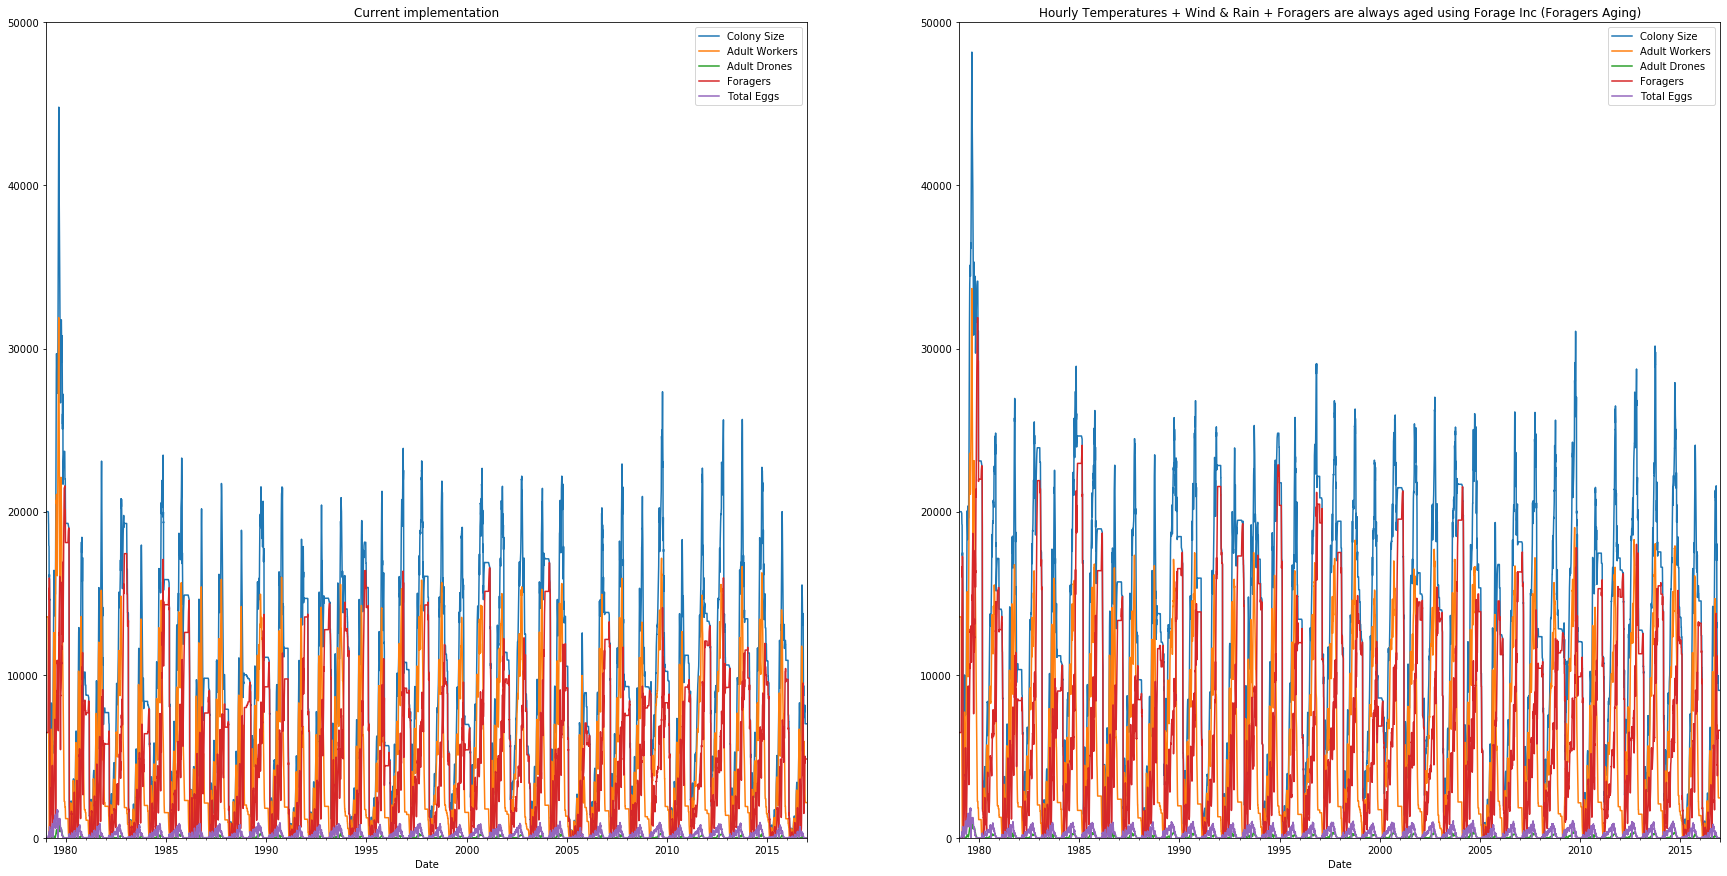

In [30]:
simulations_output_directory = 'results\walla-walla'
#historical_data_filename = 'observed-requeen-data_46.03125_-118.34375'
historical_data_filename = 'observed-requeen-delay-5days-data_46.03125_-118.34375'
ww_historical_output_directory = os.path.join(simulations_output_directory, historical_data_filename)
future_data_filename = 'rcp85-requeen-data_46.03125_-118.34375'
ww_future_output_directory = os.path.join(simulations_output_directory, future_data_filename)

walla_walla_historical = {
    'current' : Data.load_data(current, ww_historical_output_directory),
    'adults_aging_when_egg_laid_only' : Data.load_data(adults_aging_when_egg_laid_only, ww_historical_output_directory),
    'hourly_temperature' : Data.load_data(hourly_temperature, ww_historical_output_directory),
    'hourly_temperature_forage_day_wind_and_rain' : Data.load_data(hourly_temperature_forage_day_wind_and_rain, ww_historical_output_directory),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first, ww_historical_output_directory),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers, ww_historical_output_directory),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid, ww_historical_output_directory)
}

# Columns to be printed on the X axis of graphs when needed
bees_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers']
bees_extended_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', "Capped Drone Brood", "Capped Worker Brood", "Drone Larvae", "Worker Larvae", "Drone Eggs"]
bees_and_eggs_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Total Eggs']
bees_active_inactive_foragers_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Inactive Foragers']
            
options = Options()

# Current vs Egg laying data
options.data = PlotsData(walla_walla_historical['current'], walla_walla_historical['adults_aging_when_egg_laid_only'])
# ['1979-02-01', '1979-08-01']
# [0, 10000]

# Current vs Adult age as Forager using Forage Inc
options.data = PlotsData(walla_walla_historical['current'], walla_walla_historical['hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers'])
# ['1996-01-01', '1999-01-01']

# Current vs Forager age using Forage Inc
options.data = PlotsData(walla_walla_historical['current'], walla_walla_historical['hourly_temperature_forage_day_wind_and_rain_foragers_first'])
# ['1996-01-01', '1999-01-01']

# Adult age as Forager using Forage Inc vs Forager age using Forage Inc
options.data = PlotsData(walla_walla_historical['current'], walla_walla_historical['hourly_temperature_forage_day_wind_and_rain_foragers_first'])
# ['1997-01-01', '1998-01-01']
# [0, 40000]
# better view of egg laying pattern
# [0, 5000]
# egg laying delay
# ['1997-07-20', '1997-08-15']

options.columns = bees_and_eggs_columns
options.layout = Option(
    activated = True,
    params = BeesPlots.Type.LEFT
)
options.x_limit = Option(
    activated = False,
    params = ['1997-07-20', '1997-08-15']
)
options.y_limit = Option(
    activated = True,
    params = [0, 50000]
)
options.eggs = Option(
    activated = True,
    params = None
)
options.drones = Option(
    activated = True,
    params = None
)
options.larvas = Option(
    activated = True,
    params = None
)
options.temperatures = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_day = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
    
BeesPlots.make_plot(options)


### Future

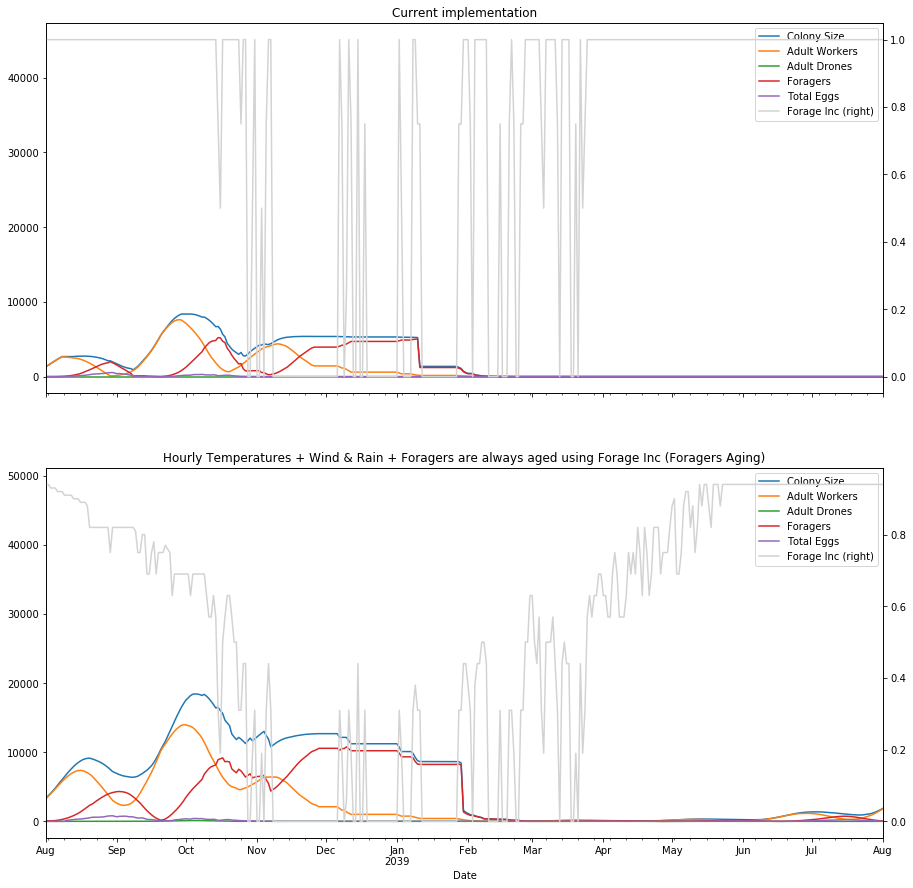

In [68]:
walla_walla_future = {
    'current' : Data.load_data(current, ww_future_output_directory),
    'adults_aging_when_egg_laid_only' : Data.load_data(adults_aging_when_egg_laid_only, ww_future_output_directory),
    'hourly_temperature' : Data.load_data(hourly_temperature, ww_future_output_directory),
    'hourly_temperature_forage_day_wind_and_rain' : Data.load_data(hourly_temperature_forage_day_wind_and_rain, ww_future_output_directory),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first, ww_future_output_directory),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers' : Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_as_foragers, ww_future_output_directory),
    'hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid': Data.load_data(hourly_temperature_forage_day_wind_and_rain_foragers_first_adults_aging_when_egg_laid, ww_future_output_directory)
}

# Columns to be printed on the X axis of graphs when needed
bees_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers']
bees_extended_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', "Capped Drone Brood", "Capped Worker Brood", "Drone Larvae", "Worker Larvae", "Drone Eggs"]
bees_and_eggs_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Total Eggs']
bees_active_inactive_foragers_columns = ['Colony Size', 'Adult Workers', 'Adult Drones', 'Foragers', 'Inactive Foragers']
            
options = Options()

options.data = PlotsData(walla_walla_future['current'], walla_walla_future['hourly_temperature_forage_day_wind_and_rain_foragers_first'])
#options.data = walla_walla_future['hourly_temperature_forage_day_wind_and_rain_foragers_first']

options.columns = bees_and_eggs_columns

options.x_limit = Option(
    activated = True,
    params = ['2038-08-01', '2039-08-01']
)
options.y_limit = Option(
    activated = False,
    params = [0, 4000]
)
options.temperatures = Option(
    activated = False,
    params = BeesPlots.Select.BOTH
)
options.forage_inc = Option(
    activated = True,
    params = BeesPlots.Select.BOTH
)
BeesPlots.make_plot(options)